##### Genome coverage threshold - Piecewise Linear Regression

**Summary** Average Nucleotide Identity (ANI) is used to define taxonomic boundries of bacterial species, where the thereshold of 95% genome identity was sugested for species separation. However, there is currently no standard, widely accepted thereshold for genus and/or species definition by alignment coverage.

The ANI analysis was run on 297 type genomes with pyANI v3. One of the pyANI graphical outputs includes the scatterplot of identity and coverage, which can be used to predict likley coverage threshold for subdivision by applying picewise linear regression. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf
from pathlib import Path

Once the ANI analysis is run with pyANI v3, the results are places in a local SQLite database. These results can be quaired from the database by `pyANI report` command line. 

Loading coeverage and identity data.

In [18]:
coverage = np.array([_ for _ in np.array(pd.read_csv(Path("../output/pyani_matrices/matrix_coverage_1.tab"), sep='\t').set_index("Unnamed: 0").values.flatten()) if _ != 1.0])

In [19]:
identity = np.array([_ for _ in np.array(pd.read_csv(Path("../output/pyani_matrices/matrix_identity_1.tab").expanduser(), sep='\t').set_index('Unnamed: 0').values.flatten()) if _ != 1.0])

In [20]:
cov = pd.read_csv(Path("../output/pyani_matrices/matrix_coverage_1.tab"), sep='\t').values.flatten()

Recreating the identity vs coverage scatter plot. 

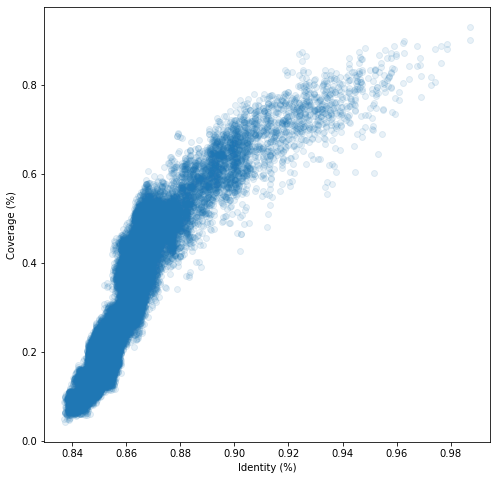

In [21]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 8))

# Set axis labels
ax.set_xlabel('Identity (%)')
ax.set_ylabel('Coverage (%)')


# Create scatter plot with colored points
plt.scatter(identity, coverage, alpha=0.1)

# Save the figure
fig.savefig("identity_vs_coverage.pdf")

plt.show()


Identification of breakpoints. 

In [22]:
import piecewise_regression
import numpy as np
ms = piecewise_regression.ModelSelection(identity, coverage, max_breakpoints=9)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 
Running fit with n_breakpoint = 7 . . 
Running fit with n_breakpoint = 8 . . 
Running fit with n_breakpoint = 9 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                -5.0245e+05         True       264.29 
1                -5.5316e+05         True       147.24 
2                -5.6657e+05         True       126.12 
3                -5.6928e+05         True        122.2 
4                -5.6968e+05         True       121.61 
5                -5.6989e+05         True       121.29 
6                                   False    

**pwlf**

[pwlf](https://pypi.org/project/pwlf/) is a python library for fotting continuous peiecewise linear function data, by specifying the number of desired line segments. 

In [37]:
def fit_piecewise(x_axis, y_axis, segments, seed_num, output_file):
    """Return scatterplot with piecewise linear
    regression, and print values at breaks at y and x axis. 
    
    :param x_axis: x-axis data
    :param y_axis: y-axis data
    :param segments: number of desired line segment (int)
    :param seed_num: seed number (int) for reproductibity purposes only
    """


    #Piecewise lienar regression 
    my_pwlf = pwlf.PiecewiseLinFit(x_axis, y_axis, seed=seed_num)
    breaks_x = my_pwlf.fit(segments)
    x_hat = np.linspace(x_axis.min(), x_axis.max(), len(x_axis))
    y_hat = my_pwlf.predict(x_hat)

    
    #Plotting the graph
    plt.figure()
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.plot(x_axis, y_axis, 'o', alpha=0.1, color='#0b83a4')
    plt.plot(x_hat, y_hat, '-', color='red')
    # Set x and y axis labels with larger font size
    plt.xlabel('Identity (%)', fontsize=20)
    plt.ylabel('Coverage (%)', fontsize=20)

    # Increase tick size on both axes
    plt.tick_params(axis='both', which='major', labelsize=16)

    plt.show()
    fig.savefig(output_file)
    
    print(f"The breakpoints at xaxis are: {breaks_x}")
    breaks_y = [np.interp(_, x_hat,y_hat) for _ in breaks_x]
    print(f"The breakpoints at yaxis are: {breaks_y}")
    

<Figure size 432x288 with 0 Axes>

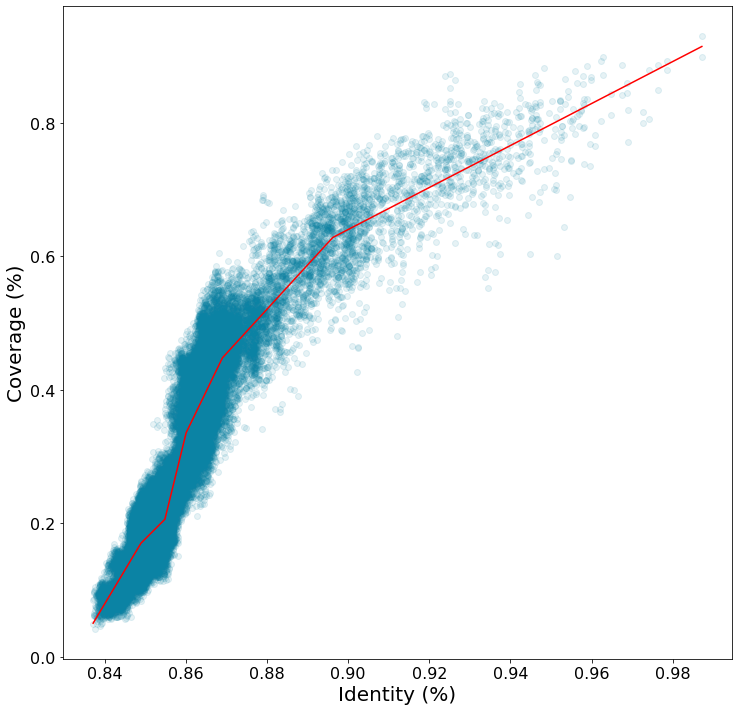

The breakpoints at xaxis are: [0.83711447 0.84883699 0.854796   0.85999747 0.86893622 0.8961323
 0.98719398]
The breakpoints at yaxis are: [0.05061353987435836, 0.17006197254967165, 0.2060139442938117, 0.33530622028940066, 0.44774915893938555, 0.6282060616867603, 0.9145047380713955]


In [38]:
fit_piecewise(identity, coverage, 6, 14848484, Path("piecewise_linear_regression_6_segments.pdf").expanduser())

<Figure size 432x288 with 0 Axes>

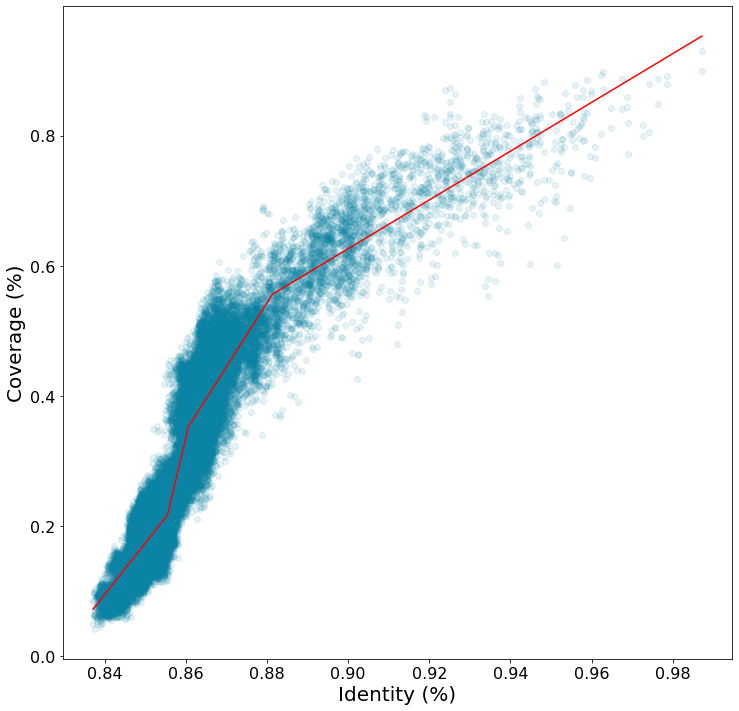

The breakpoints at xaxis are: [0.83711447 0.85544495 0.86055555 0.88125016 0.98719398]
The breakpoints at yaxis are: [0.07228261798806036, 0.21708630163892245, 0.3521513642299512, 0.5561293006492329, 0.9530775374473945]


In [39]:
fit_piecewise(identity, coverage, 4, 14848484, Path("piecewise_linear_regression_4_segments.pdf").expanduser())

In [11]:
pw_fit = piecewise_regression.Fit(identity, coverage, n_breakpoints=5)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                    86730
No. Model Parameters                   12
Degrees of Freedom                  86718
Res. Sum of Squares               121.404
Total Sum of Squares               1356.1
R Squared                        0.910476
Adjusted R Squared               0.910464
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -4.47415        0.379      -11.815      3.48e-32      -5.2164      -3.7319
alpha1               5.43254         0.45       12.083      1.38e-33       4.5513       6.3137
beta1                14.0572         1.38       10.218             -       11.361       16.754
beta2               -13.1137          1.3      -10.063             -      -15.668       -10.56
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                    86730\nNo. Model Parameters                   12\nDegrees of Freedom                  86718\nRes. Sum of Squares               121.404\nTotal Sum of Squares               1356.1\nR Squared                        0.910476\nAdjusted R Squared               0.910464\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -4.47415        0.379      -11.815      3.48e-32      -5.2

In [36]:
import pandas as pd
from collections import Counter
data = pd.read_csv("../../supplementary_file_9/output/pyANI_genus_IDs.csv")

print(Counter(Counter([_ for _ in data["genus_ID_pc_4_with_ID"]]).values()))

Counter({1: 36, 2: 14, 3: 7, 4: 6, 16: 2, 5: 2, 7: 2, 15: 2, 6: 2, 20: 1, 17: 1, 10: 1, 19: 1, 14: 1, 8: 1})


<Figure size 432x288 with 0 Axes>

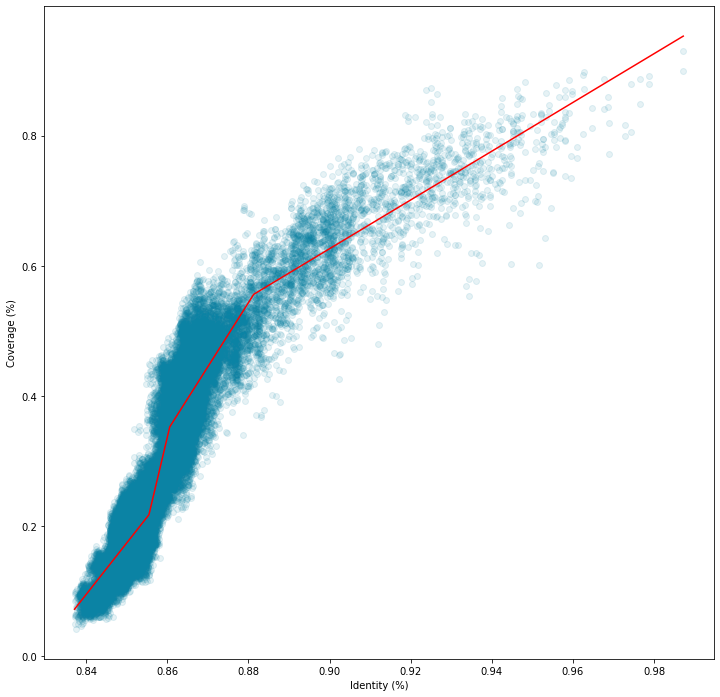

The breakpoints at xaxis are: [0.83711447 0.85544495 0.86055555 0.88125016 0.98719398]
The breakpoints at yaxis are: [0.07228261798806036, 0.21708630163892245, 0.3521513642299512, 0.5561293006492329, 0.9530775374473945]


In [38]:
fit_piecewise(identity, coverage, 4, 14848484, Path("piecewise_linear_regression_3_segments.pdf").expanduser())

In [25]:
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=3)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                    86730
No. Model Parameters                    8
Degrees of Freedom                  86722
Res. Sum of Squares               122.203
Total Sum of Squares               1356.1
R Squared                        0.909887
Adjusted R Squared               0.909879
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -6.54037       0.0475      -137.62           0.0      -6.6335      -6.4472
alpha1               7.89935       0.0559       141.42           0.0       7.7899       8.0088
beta1                18.5379        0.283       65.602             -       17.984       19.092
beta2               -16.5798        0.285      -58.201             -      -17.138      -16.021
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                    86730\nNo. Model Parameters                    8\nDegrees of Freedom                  86722\nRes. Sum of Squares               122.203\nTotal Sum of Squares               1356.1\nR Squared                        0.909887\nAdjusted R Squared               0.909879\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -6.54037       0.0475      -137.62           0.0      -6.6

<Figure size 432x288 with 0 Axes>

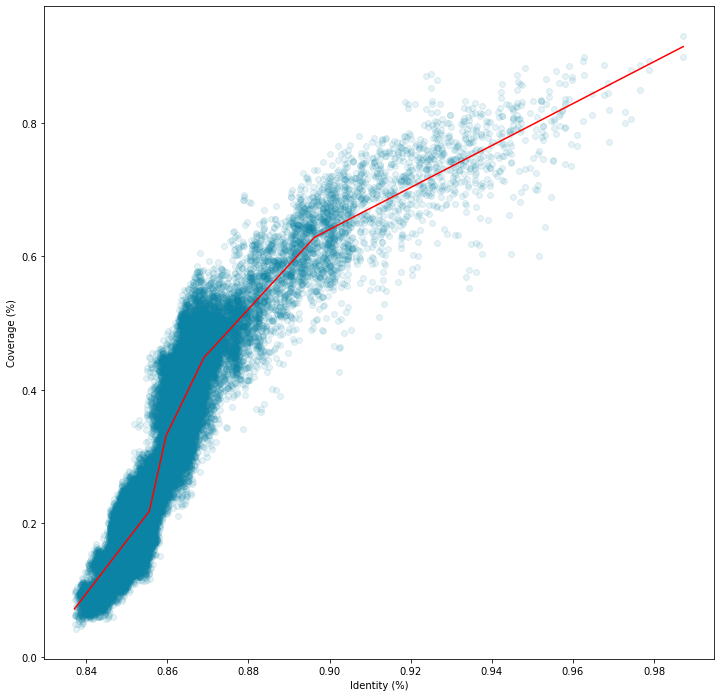

The breakpoints at xaxis are: [0.83711447 0.85553432 0.85966289 0.86898561 0.89622107 0.98719398]
The breakpoints at yaxis are: [0.07207302762772985, 0.21790904824264934, 0.3311924781030961, 0.4482480728283275, 0.6285842958443204, 0.9143470414777572]


In [39]:
fit_piecewise(identity, coverage, 5, 14848484, Path("piecewise_linear_regression_3_segments.pdf").expanduser())

In [40]:
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=4)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                    86730
No. Model Parameters                   10
Degrees of Freedom                  86720
Res. Sum of Squares               121.607
Total Sum of Squares               1356.1
R Squared                        0.910326
Adjusted R Squared               0.910316
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -8.48661        0.127      -66.903           0.0      -8.7352       -8.238
alpha1               10.1983         0.15       68.059           0.0       9.9046       10.492
beta1               -4.24211        0.192      -22.041             -      -4.6193      -3.8649
beta2                18.0428        0.214       84.505             -       17.624       18.461
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                    86730\nNo. Model Parameters                   10\nDegrees of Freedom                  86720\nRes. Sum of Squares               121.607\nTotal Sum of Squares               1356.1\nR Squared                        0.910326\nAdjusted R Squared               0.910316\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -8.48661        0.127      -66.903           0.0      -8.7

<Figure size 432x288 with 0 Axes>

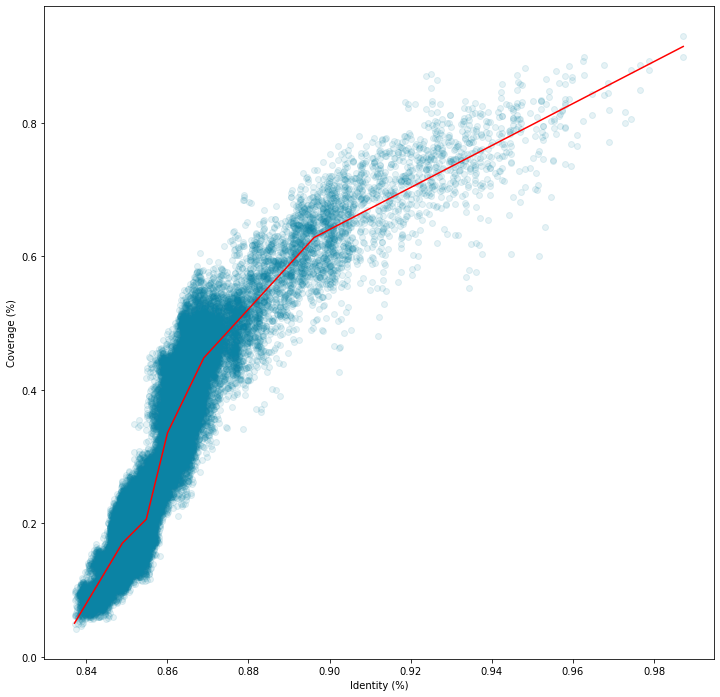

The breakpoints at xaxis are: [0.83711447 0.84883699 0.854796   0.85999747 0.86893622 0.8961323
 0.98719398]
The breakpoints at yaxis are: [0.05061353987435836, 0.17006197254967165, 0.2060139442938117, 0.33530622028940066, 0.44774915893938555, 0.6282060616867603, 0.9145047380713955]


In [41]:
fit_piecewise(identity, coverage, 6, 14848484, Path("piecewise_linear_regression_3_segments.pdf").expanduser())

<Figure size 432x288 with 0 Axes>

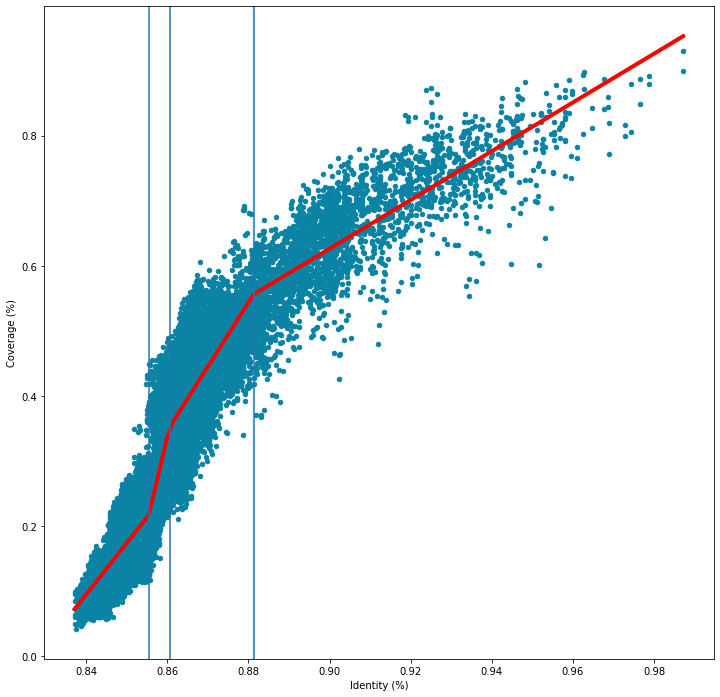

In [33]:
import matplotlib.pyplot as plt

# Plot the data, fit, breakpoints and confidence intervals
plt.figure()
fig, ax = plt.subplots(figsize=(12, 12))
pw_fit.plot_data(color="#0b83a4", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel('Identity (%)')
plt.ylabel('Coverage (%)')
plt.show()
plt.close()


In [27]:
# Get the key results of the fit
pw_results = pw_fit.get_results()
pw_estimates = pw_results["estimates"]

In [34]:
pw_results

{'estimates': {'const': {'estimate': -6.540372063715306,
   'se': 0.04752657498960032,
   'confidence_interval': (-6.633523739105785, -6.447220388324828),
   't_stat': -137.61505147691494,
   'p_t': 0.0},
  'beta1': {'estimate': 18.537884834371738,
   'se': 0.2825815215400015,
   'confidence_interval': (17.984027499362817, 19.09174216938066),
   't_stat': 65.60190041211723,
   'p_t': '-'},
  'breakpoint1': {'estimate': 0.8554451806842329,
   'se': 4.187659304500639e-05,
   'confidence_interval': (0.8553631029245239, 0.855527258443942),
   't_stat': '-',
   'p_t': '-'},
  'beta2': {'estimate': -16.579784623648017,
   'se': 0.284873412048743,
   'confidence_interval': (-17.138134044205867, -16.021435203090167),
   't_stat': -58.200533719205595,
   'p_t': '-'},
  'breakpoint2': {'estimate': 0.8605531060826582,
   'se': 6.319817762105271e-05,
   'confidence_interval': (0.8604292382018291, 0.8606769739634873),
   't_stat': '-',
   'p_t': '-'},
  'beta3': {'estimate': -6.110644351593924,
   

In [30]:
print(breakpoint_confidence_intervals())

NameError: name 'breakpoint_confidence_intervals' is not defined